# Classical Supervised Learning

Supervised machine learning is when we use a dataset **with known structure and/or features** to teach an algorithm how to approximate a function

$$ y = f(x) $$

between the data $x$ and the known outcome $y$. Classical machine learning is the machine learning algorithms that are not deep neural networks. Thus classical supervised learning is achieved by approximating the function $f$ using alternative methods to deep neural networks.

In this exercise notebook we will look at different datasets, their structure and how to classify the data in the datasets. On top of this we will see how shallow neural networks can be used as **universal function approximators**.

We will start by classifying the same dataset using different classification methods and how this affects the accuracy and the placement of the decision boundary in the dataset.

In [17]:
%matplotlib notebook
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy import special
from IPython.core.display import display,HTML
display(HTML("<style>.container{ width: 100% !important;} <\style>"))
import warnings
warnings.filterwarnings("ignore",category=FutureWarning,append=True)

## Aside: plotting code

I have provided a plotting code to plot the results of a classifier and the decision boundaries. This is provided as an easy to use function as I didn't see the need for anyone else to have to struggle with `matplotlib` to make these plots.

In [2]:
def class_plot(data,targets,feature_names,classifier,rang=0.25):
    '''
    A function to make the boundary contour plots.
    
    Parameters
    ----------
    data : numpy.ndarray
        The feature data.
    targets : numpy.ndarray
        The labels of the data samples.
    feature_names : list
        A list of the names of the features to be compared.
    classifier : various
        The class instance for the classifier being used after training.
    rang : float
        Defines the range of the x-axis and y-axis.
    '''
    
    x_min, x_max = data[:,0].min() - rang, data[:,0].max() + rang
    y_min, y_max = data[:,1].min() - rang, data[:,1].max() + rang
    
    xx, yy = np.meshgrid(np.arange(x_min,x_max,0.02),np.arange(y_min,y_max,0.02))
    
    if hasattr(classifier,"decision_function"):
        Z = classifier.decision_function(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
    else:
        Z = classifier.predict_proba(np.c_[xx.ravel(),yy.ravel()])[:,1].reshape(xx.shape)

    cm = ListedColormap(["#FF0000","#0000FF"])

    plt.figure()
    plt.contourf(xx,yy,Z,cmap="RdBu",alpha=0.8)
    plt.scatter(data[:,0],data[:,1],c=targets,cmap=cm)
    plt.ylabel(feature_names[1])
    plt.xlabel(feature_names[0])

## Classification Dataset

Next we must load the dataset. The data is saved in ```.npz``` format. This is a data format native to ```numpy``` and works to save multiple ```numpy``` arrays to disk without losing any information. For more information check out the [`scipy` documentation](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.lib.format.html#module-numpy.lib.format). ```.npz``` is essentially a ```.zip``` of ```numpy``` arrays. Loading a ```.npz``` file returns a ```dict```-like object where the arrays have the keys corresponding to the names assigned when saving the file. e.g.

```python
>>> import numpy as np
>>> a = np.array([[1,2],[3,4]])
>>> np.savez_compressed("a.npz",data=a)
>>> f = np.load("a.npz")
>>> f["data"] == a
array([[True, True],
       [True, True]])
```

In the example above, we use the function ```savez_compressed``` to save the data which creates a compressed ```.npz``` file but the function ```savez``` to create an uncompressed ```.npz``` file also exists (but when loading the data will make your code slower. ```.npz``` files preserve the structure of the arrays so there is no need to worry about doing any data manipulations when working with these files.

In [3]:
data = np.load("data.npz")

In [4]:
list(data.keys()) #this tells you what is in the dataset

['features', 'labels']

## Classification Method #1: The Perceptron

The perceptron is the simplest machine learning algorithm as it consists of a linear transformation followed by a non-linear step function to calculate its output. This is essentially one "neuron" of a layer of a neural network. This can be trained for only linear tasks and our dataset is a non-linear binary classification set which can be reflected in the perfomance.

1. Create a perceptron instance.
2. Next, fit this to the data and check the accuracy.
3. Lastly, plot your reduced data showing the decision boundaries using the plotting code provided.

**Feel free to change the tolerance level in the perceptron class instance to try to improve convergence (or make it worse).**
**Make sure to always choose** `random_state` **to be the same number when creating the class instance otherwise it will train differently every time.**

In [5]:
X, y = data["features"], data["labels"]

In [6]:
p = Perceptron(tol=1e-3,random_state=0)
p.fit(X,y)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
p.score(X,y)

0.83

<IPython.core.display.Javascript object>


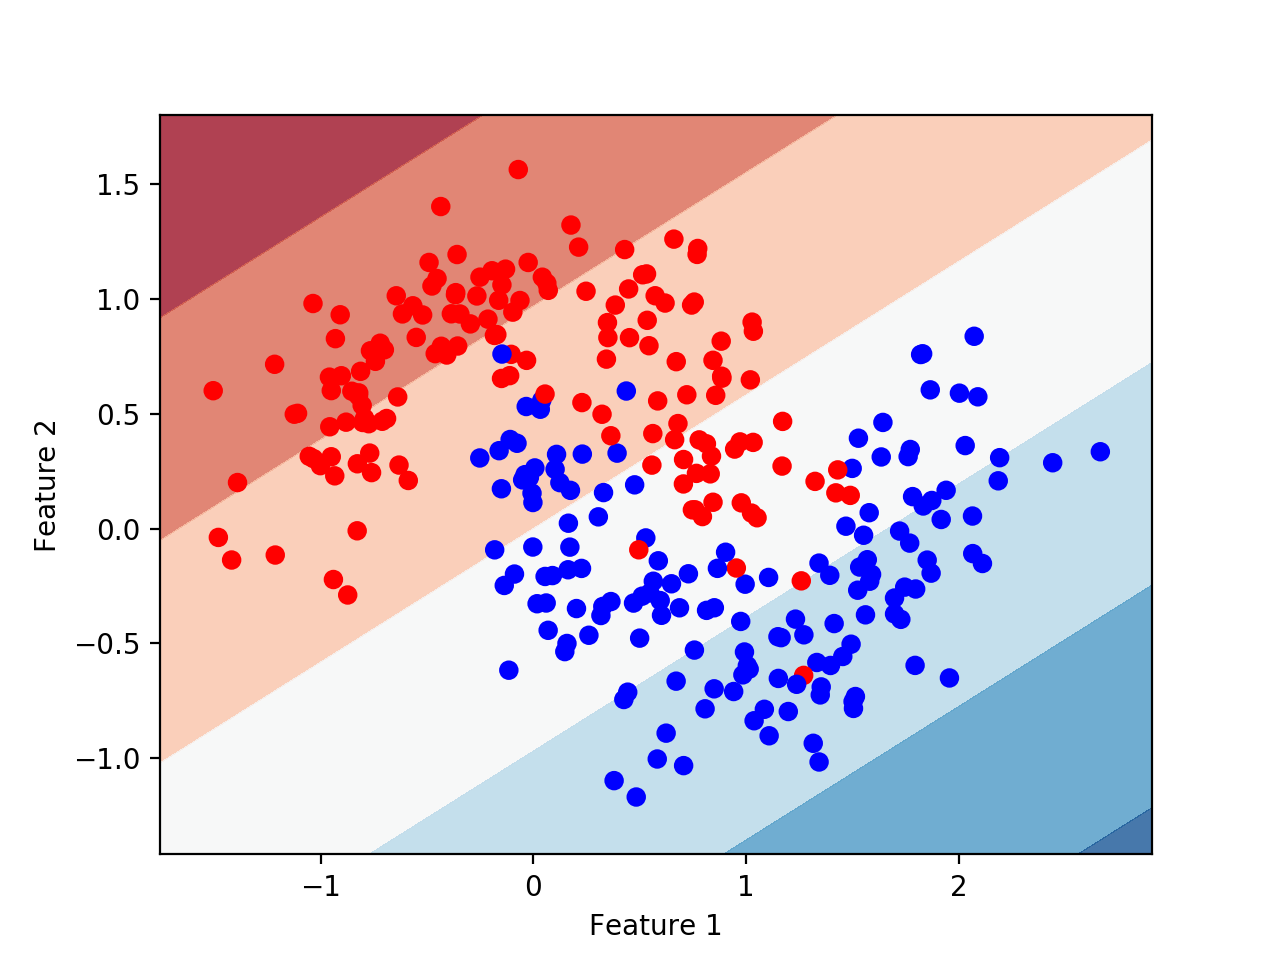

In [8]:
class_plot(X,y,["Feature 1","Feature 2"],p)

## Classification Method #2: K-Nearest Neighbours

K-nearest neighbours is a instance-based classifier and rather than learning a general model, this method learns information about the training data (i.e. where they lie in the 2D plane) to choose where to put the data it has not seen before. Classification in this case is performed by a majority vote, the distance from a point to the k nearest neighbours is calculated and the minimal distance defines what class the point belongs to.

The process is the same as that above.

**Try different numbers of nearest neighbours to see which gives you the best accuracy.**

In [9]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [10]:
knn.score(X,y)

0.9733333333333334

<IPython.core.display.Javascript object>


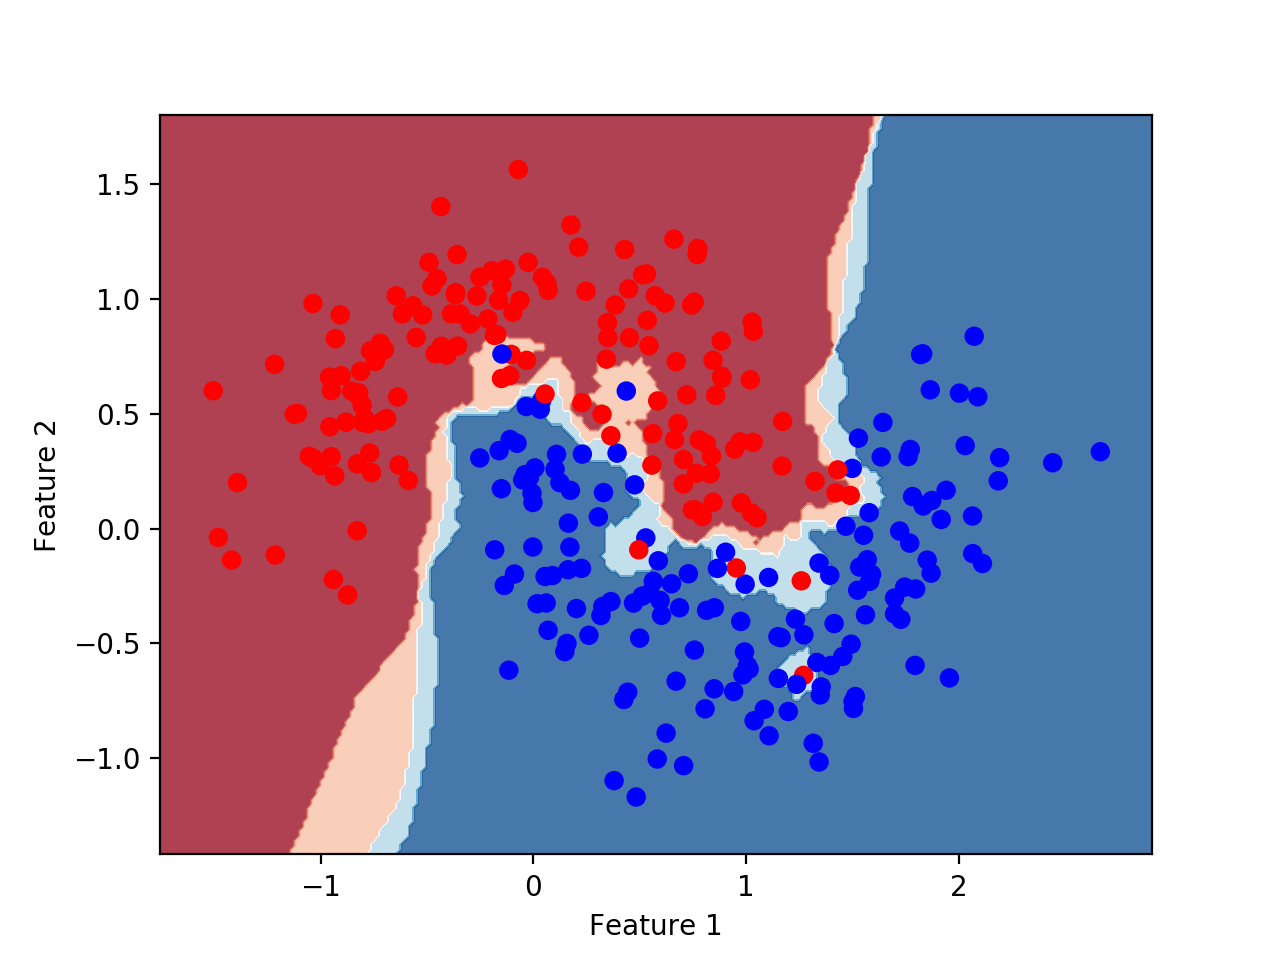

In [11]:
class_plot(X,y,["Feature 1","Feature 2"],knn)

## Classification Method #3: Gaussian Processes

A Gaussian process is one in which each of the classes in the dataset is assumed to be normally distributed i.e. drawn from a multivariate normal distribution. The distribution of the entire process is then the joint distribution of the features and is thus a continuous distribution in the space we are working.

We start from the assumption that each class is drawn from a normal with zero mean and a covariance matrix that we would like to learn to represent the data. This covariance matrix is often referred to as the kernel of the Gaussian process and is something that can be changed to yield different results. Starting from a Gaussian and calculating the covariance between the points in the classes allows the distribution of each class to be jointly updated until convergence.

**For the dataset provided, try different covariance matrices to see which converges the best.**

In [13]:
gp = GaussianProcessClassifier()
gp.fit(X,y)

GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)

In [14]:
gp.score(X,y)

0.91

<IPython.core.display.Javascript object>


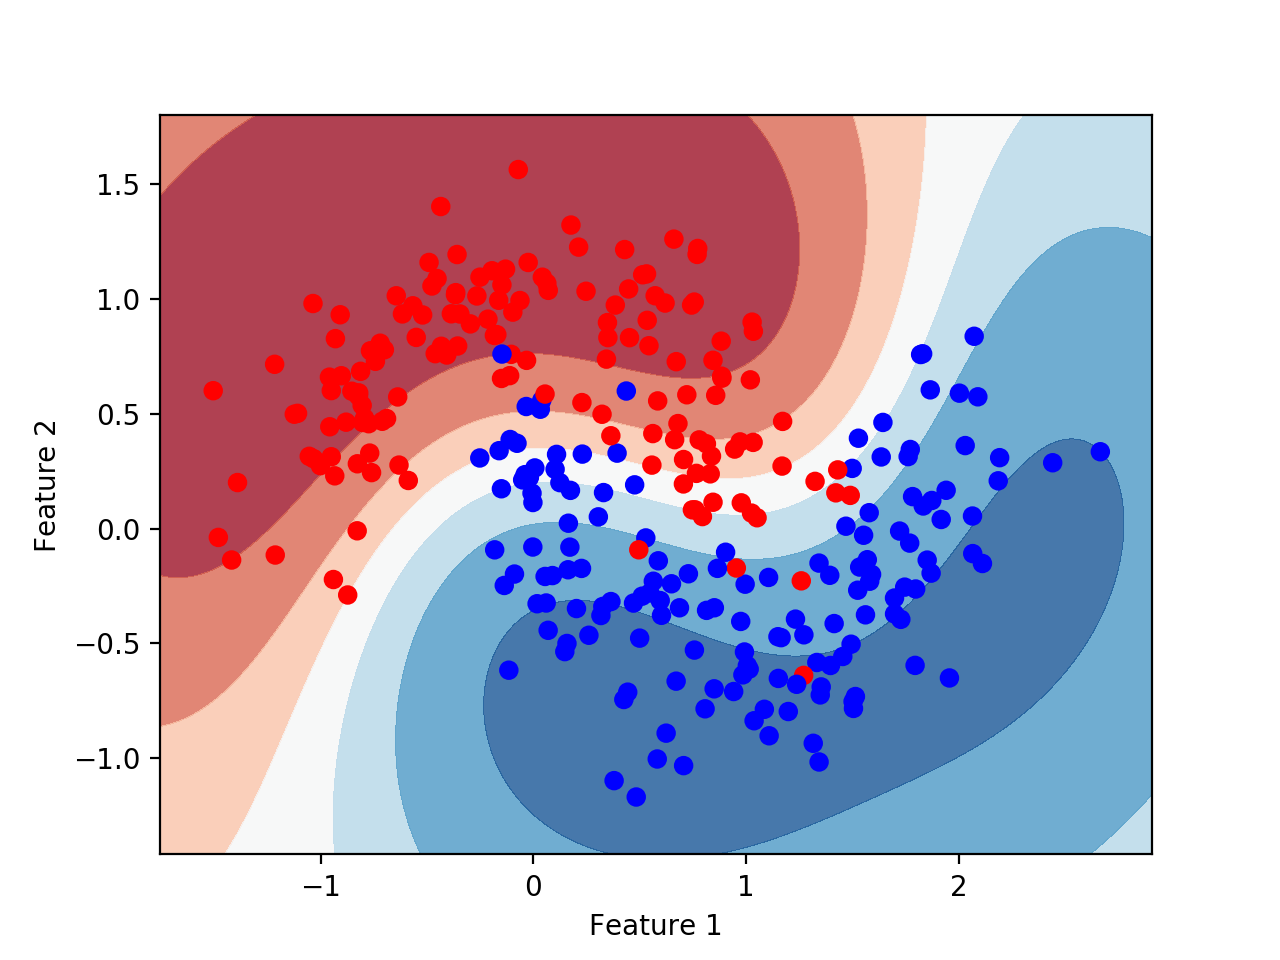

In [15]:
class_plot(X,y,["Feature 1","Feature 2"],gp)

## Classification Method #4: Support Vector Machine (SVM)

The last classification technique we will employ is the support vector machine (SVM). Support vector machines find a non-linear transformation in the dimension one higher than the dimension of the data to find a hyperplane which makes the data linearly separable. The "support vectors" are the points in the plane closest to the boundary of this hyperplane to help refine the position of it.

**Try different kernels to see which transformation yields the best solution.**

In [18]:
svm = SVC()
svm.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
svm.score(X,y)

0.9566666666666667

<IPython.core.display.Javascript object>


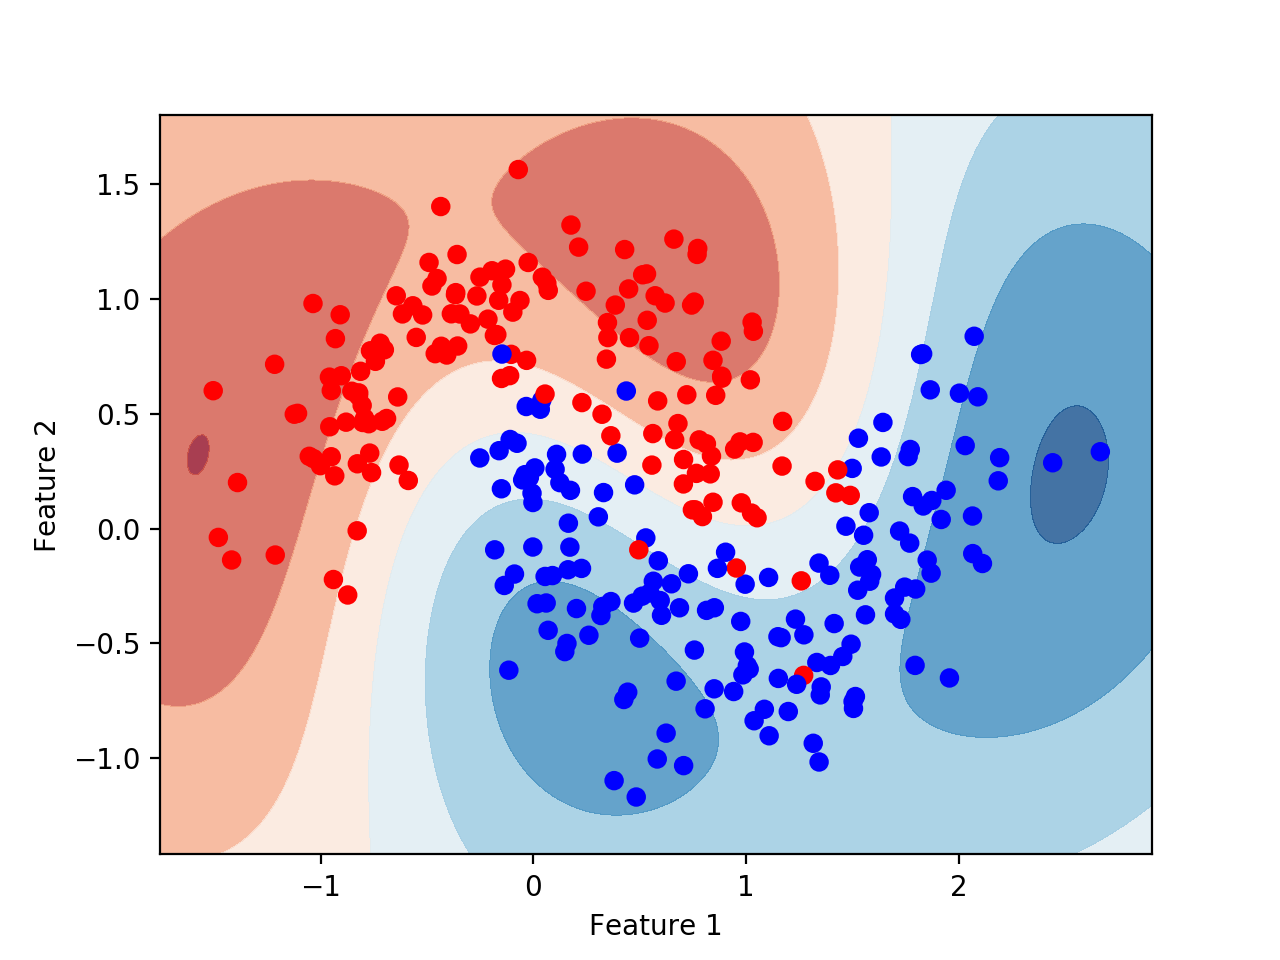

In [20]:
class_plot(X,y,["Feature 1","Feature 2"],svm)

## Function Approximation using SVMs and Neural Networks

The follow is an exercise on function approximating with support vector machines (SVMs) and neural networks. The neural network here has one layer between the input and output and is well-versed at function approximation. The dataset we use here is `voigt.npz`. This is the Voigt H function for damping factor a = 1, i.e.,

$$ H (a, v) = \frac{a}{\pi} \int_{0}^{\infty} \frac{e^{- (v^{\prime})^{2}}}{(a^{2} + (v - v^{\prime})^{2}} dv^{\prime} $$

The profile made for a range in v and a = 1 then has random Gaussian noise applied to it and we want to see how well we can approximate this, first using an SVM and second using a shallow neural network. After learning the function try plotting the true line profile (also given in the data file) to see how well your fit done.

In [21]:
voigt = np.load("voigt.npz")

In [23]:
list(voigt.keys())

['inputs', 'profile', 'true_profile']

In [24]:
X, y = voigt["inputs"], voigt["profile"]

In [26]:
svm = SVR()
svm.fit(X.reshape(-1,1),y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
y_rbf = svm.predict(X.reshape(-1,1))

<IPython.core.display.Javascript object>


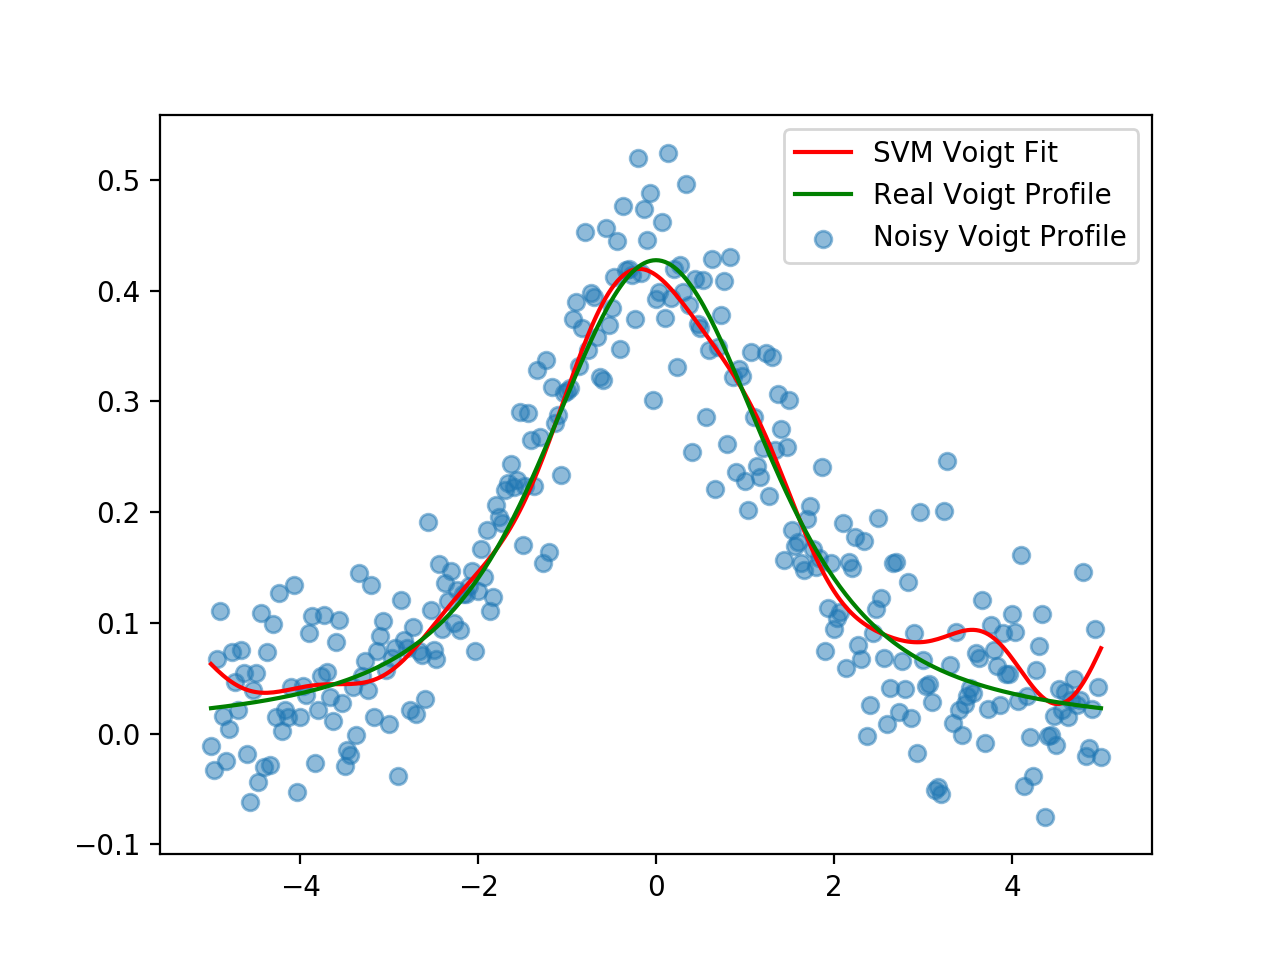

In [30]:
plt.figure()
plt.plot(X,y_rbf,label="SVM Voigt Fit",color="r")
plt.scatter(X,y,alpha=0.5,label="Noisy Voigt Profile")
plt.plot(X,voigt["true_profile"],label="Real Voigt Profile",color="g")
plt.legend()

For the neural network approach we must define the model, the datasets, the loss function and the numerical method for optimisation. A template for this example is shown below but can be edited if you feel the need to.

In [31]:
model = nn.Sequential(
    nn.Linear(1,100),
    nn.Sigmoid(),
    nn.Linear(100,1)
)

loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),lr=0.01)

In [32]:
xy = np.stack((X,y),axis=1)
xy_train, xy_test = train_test_split(xy,test_size=0.1)
x_train, y_train = xy_train[:,0], xy_train[:,1]
x_test, y_test = xy_test[:,0], xy_test[:,1]

In [33]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(x_train).float(),torch.from_numpy(y_train).float()),shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(x_test).float(),torch.from_numpy(y_test).float()))

In [34]:
for t in range(500):
    for item, ans in train_loader:
        optimiser.zero_grad()

        y_pred = model(item)

        loss = loss_fn(y_pred,ans)

        loss.backward()

        optimiser.step()
    
    for item, ans in test_loader:
        with torch.no_grad():
            y_pred_test = model(item)

            loss_test = loss_fn(y_pred_test,ans)

    print(t, loss_test.item())

0 0.003956987522542477
1 0.012377770617604256
2 0.00011962301505263895
3 0.010329331271350384
4 0.008773860521614552
5 0.0030836956575512886
6 0.004432651214301586
7 0.0015385098522529006
8 0.005119733512401581
9 0.003945772536098957
10 0.0006846283213235438
11 0.0011219250736758113
12 0.00012245749530848116
13 0.0002129065542249009
14 0.00020502493134699762
15 3.0679799237987027e-05
16 0.00944551546126604
17 0.02182421274483204
18 6.12021831329912e-05
19 0.011792457662522793
20 0.0041642882861196995
21 0.0001401965564582497
22 0.0009489258518442512
23 0.0004908725968562067
24 1.2921856068714987e-05
25 0.0007846467779017985
26 4.613049895851873e-05
27 0.0011895071947947145
28 0.00021617700986098498
29 0.008144061081111431
30 0.002385281026363373
31 0.0017265231581404805
32 0.005182537250220776
33 2.767506430245703e-06
34 0.0011961495038121939
35 9.26305292523466e-05
36 0.0012735954951494932
37 0.00010621699038892984
38 0.0004992635804228485
39 0.012031739577651024
40 0.0010190214961767

323 0.00010369790834374726
324 0.0038895858451724052
325 0.0020795573946088552
326 0.0030590028036385775
327 0.000379171222448349
328 0.00013237810344435275
329 0.00042660266626626253
330 0.00047701914445497096
331 1.5680998330935836e-05
332 0.006825809832662344
333 4.4086980778956786e-05
334 0.0001535663177492097
335 0.001279058982618153
336 5.158016210771166e-05
337 0.005177690647542477
338 0.0008097186218947172
339 0.0001862071658251807
340 0.0007128696888685226
341 0.015537082217633724
342 7.574162737000734e-06
343 3.244241852939922e-08
344 0.000531991827301681
345 0.00018618193280417472
346 0.004568108823150396
347 7.07085055182688e-05
348 0.018026135861873627
349 0.0014684045454487205
350 0.00022045888181310147
351 0.0002993127563968301
352 0.0007769709918648005
353 0.00039680852205492556
354 0.0029763723723590374
355 0.00012733470066450536
356 0.004504053387790918
357 1.039312337525189e-06
358 0.0019480965565890074
359 0.0008197975112125278
360 5.47215313417837e-05
361 1.6318297

In [35]:
#generate a random x vector for input to the model which will calculate a learned profile (only slightly badly....)
x_test = torch.linspace(-5,5,steps=301)
with torch.no_grad():
    y_test = model(x_test.unsqueeze(1))

<IPython.core.display.Javascript object>


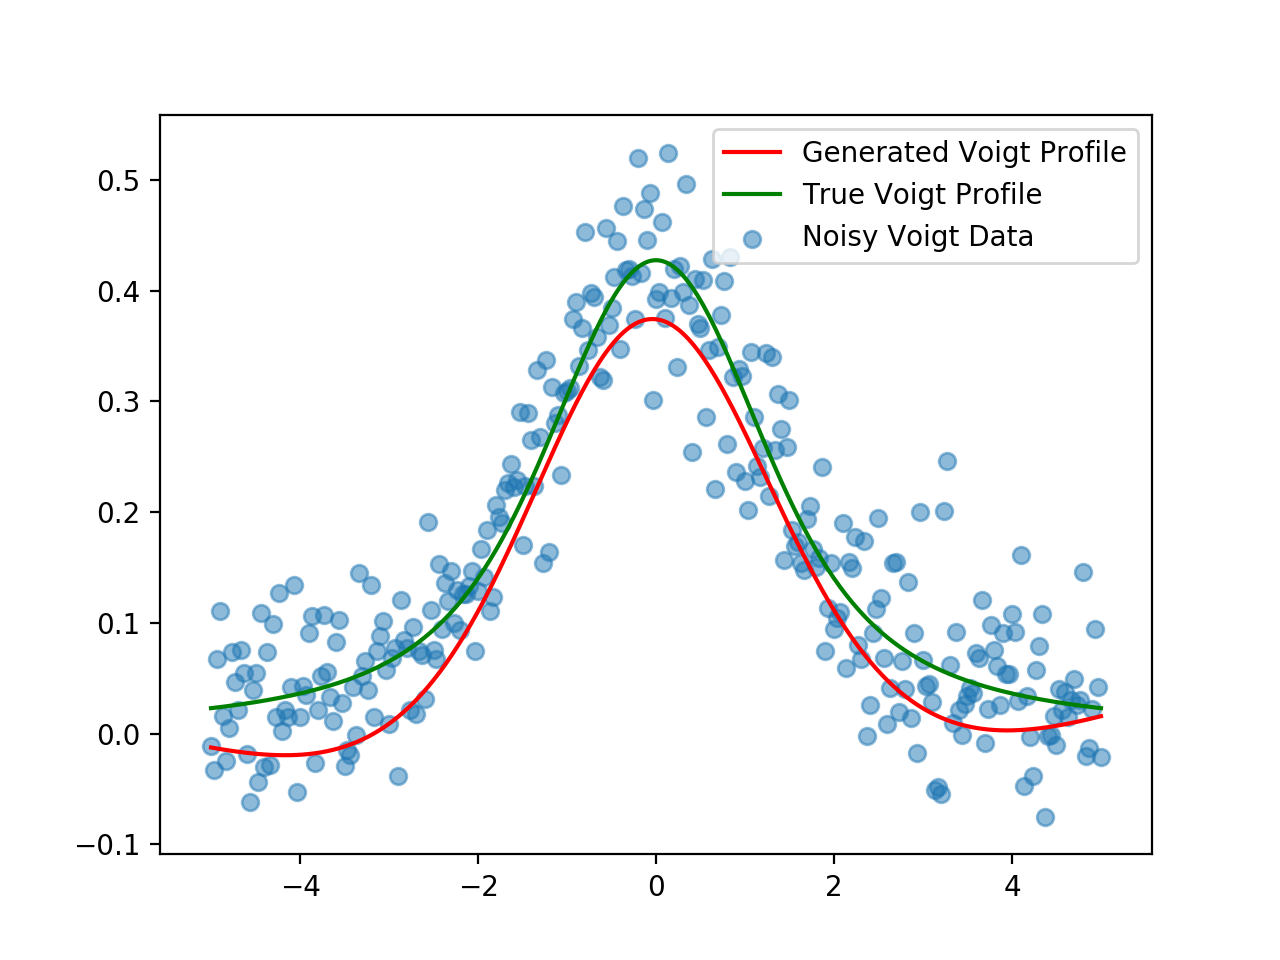

In [36]:
plt.figure()
plt.plot(x_test.numpy(),y_test.numpy(),"r",label="Generated Voigt Profile")
plt.scatter(X,y,alpha=0.5,label="Noisy Voigt Data")
plt.plot(X,voigt["true_profile"],"g",label="True Voigt Profile")
plt.legend()

## More complex function approximation using NNs

We now generalise our neural network to learn the Voigt profile for arbitrary damping factor, a (where previously we have taken a = 1). Now load in the data containing many Voigt functions. Here we train a shallow neural network to try to learn the general voigt function (the data is already provided in `general_voigt.npz`).

Try training for 500 epochs and see how well you can generate a Voigt profile by creating your own with damping factor 0 $\leq$ a $\leq$ 2. The function for making a Voigt profile is provided below.

In [37]:
def voigt_H(a,v):
    z = v + 1j * a
    return special.wofz(z).real

In [38]:
general_voigt = np.load("general_voigt.npz")

In [40]:
list(general_voigt.keys())

['a_range', 'train_data', 'test_data']

In [50]:
model = nn.Sequential(
    nn.Linear(2,1000),
    nn.Sigmoid(),
    nn.Linear(1000,1)
)

loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),lr=0.001)

In [51]:
train_input = np.stack((general_voigt["train_data"][:,:,0].flatten(),general_voigt["train_data"][:,:,1].flatten()),axis=1)
train_output = general_voigt["train_data"][:,:,2].flatten()
test_input = np.stack((general_voigt["test_data"][:,:,0].flatten(),general_voigt["test_data"][:,:,1].flatten()),axis=1)
test_output = general_voigt["test_data"][:,:,2].flatten()

In [52]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_input),torch.from_numpy(train_output)),shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(test_input),torch.from_numpy(test_output)))

In [53]:
for t in range(500):
    loss_list = []
    for item, ans in train_loader:
        item, ans = item.float(), ans.float()
        
        optimiser.zero_grad()

        y_pred = model(item)

        loss = loss_fn(y_pred,ans)

        loss.backward()

        optimiser.step()
    
    for item, ans in test_loader:
        with torch.no_grad():
            item, ans = item.float(), ans.float()
            y_pred_test = model(item)

            loss_test = loss_fn(y_pred_test,ans)

            loss_list.append(loss_test.item())
    print(t, np.mean(loss_list))

0 0.009638000318986966
1 0.007385791164283137
2 0.006089175567115167
3 0.00610389936155372
4 0.0066403841553363055
5 0.008994467690973451
6 0.005825668580577175
7 0.004966124994396761
8 0.014217239672129622
9 0.004510068971757832
10 0.005146065225504022
11 0.0047812520656614985
12 0.004167502960351873
13 0.014075705221493567
14 0.004111396171759378
15 0.005010806492853592
16 0.004576514283634052
17 0.005731343372052669
18 0.0038473387355318824
19 0.014957690863602515
20 0.004085923542373289
21 0.004445905967903457
22 0.003809162422209391
23 0.0037855911836757535
24 0.0037746110406035095
25 0.003746764459750248
26 0.005209264090721737
27 0.00663235622120824
28 0.0033314965089732388
29 0.0035233406275149023
30 0.004512330508641537
31 0.005075001220773221
32 0.0033747913945211525
33 0.0034809921584790216
34 0.0031452476552036018
35 0.003398187083793352
36 0.0033279724650974985
37 0.003936581645188959
38 0.010185080930589136
39 0.0041179342077711425
40 0.0073578784214059926
41 0.0069026757

325 0.0007213664660535643
326 0.0008892029885200238
327 0.000839195185133858
328 0.0007211751652841465
329 0.0007605593491911773
330 0.0012534909732718465
331 0.0008277558727175635
332 0.0007791757949375614
333 0.0009093061526680805
334 0.0009346536260338299
335 0.0006829291976513003
336 0.000753938630056723
337 0.0009665202277321864
338 0.0008140939381856813
339 0.0010324428784885466
340 0.0007404266431624913
341 0.0030877071673684315
342 0.0007778765817385796
343 0.0010989689325339488
344 0.0007512771070622977
345 0.0008016257425108264
346 0.0008876124828138285
347 0.0007109584628148623
348 0.000668199840964032
349 0.0008532568334716888
350 0.0007922463857674188
351 0.0012851597169826858
352 0.000674357749708763
353 0.0006483128692210562
354 0.0009668985057816531
355 0.0006630923741033152
356 0.0010026415785506818
357 0.00066506741211065
358 0.0006871848277338605
359 0.0006606392862764524
360 0.0007420608295006561
361 0.0013780578006439047
362 0.0007098488231521839
363 0.000628852151

In [54]:
v_range = np.linspace(-5,5,num=51)
a_vec = np.empty_like(v_range)
a_vec.fill(0)
x_test = np.stack((a_vec,v_range),axis=1)

x_test_tensor = torch.from_numpy(x_test).float()
with torch.no_grad():
    y_test_tensor = model(x_test_tensor)
    
real_profile = voigt_H(0,v_range)

<IPython.core.display.Javascript object>


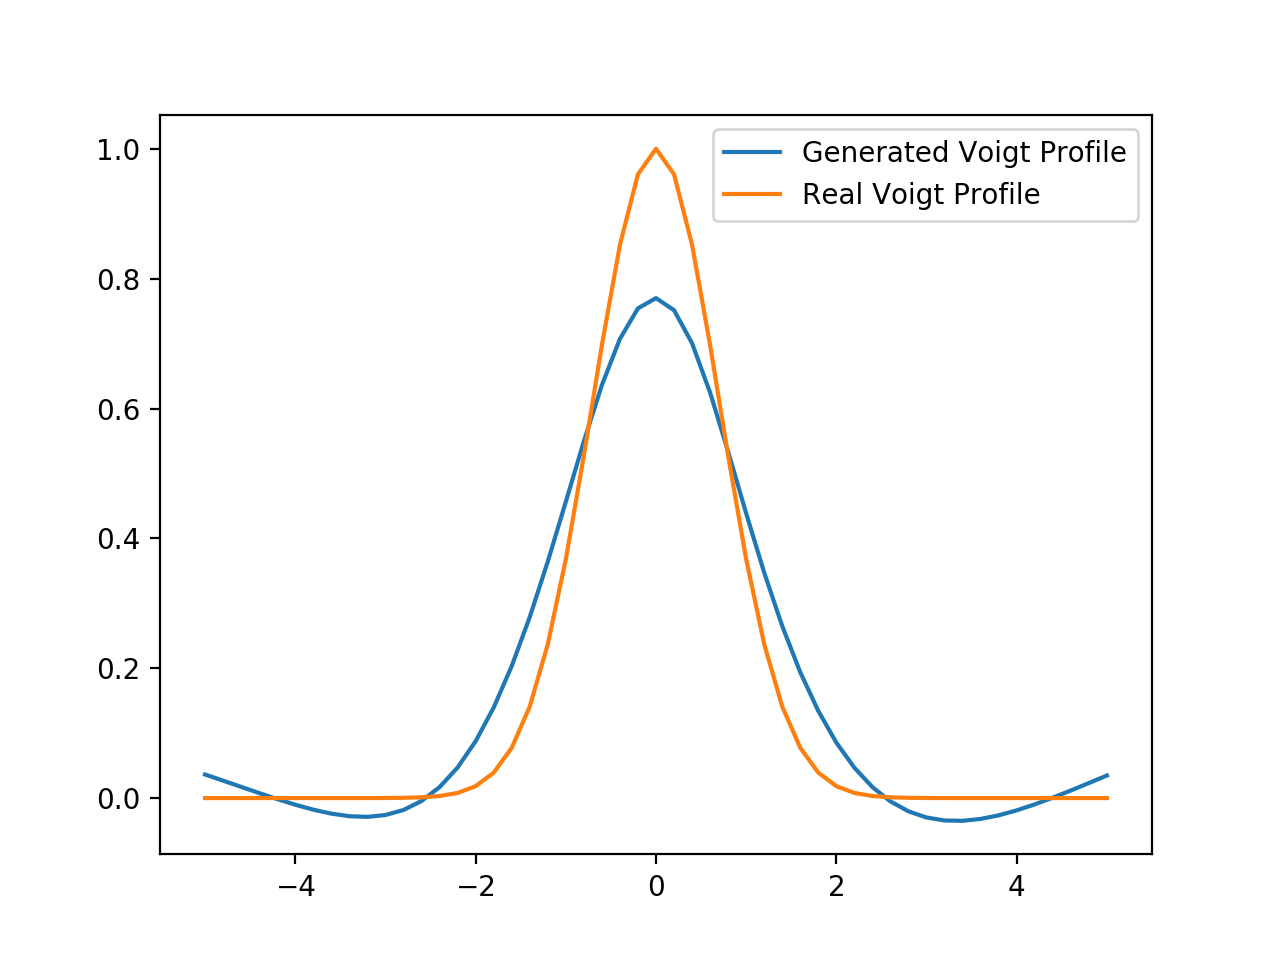

In [55]:
plt.figure()
plt.plot(v_range,y_test_tensor.numpy(),label="Generated Voigt Profile")
plt.plot(v_range,real_profile,label="Real Voigt Profile")
plt.legend()